# The Kepler-223 resonant chain system

Kepler-223 is a 4-planet resonant chain discovered by the *Kepler* mission. The system has been characterized via TTV analysis by [Mills et. al. 2016](https://ui.adsabs.harvard.edu/abs/2016Natur.533..509M/abstract). 
The planet's periods are locked in/near a 3:4:6:8 commensurability. [Delisle (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..96D/abstract)
describes an analytic model for the resonant dynamics of this (and similar) systems. This example is based on  this analytic model.

We'll proceed through a series of canonical transformations to arrive at a Hamiltonian model for the resonant interactions in this system. We'll then use this model to solve for the families of equilibrium configurations for this resonant chain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rebound as rb

## Set up a `rebound` simulation of Kepler-223

First we'll set up a `rebound` simulation of the Kepler-223 system, initializing each planet at its observed best-fit mass and orbital period. We won't worry about setting eccentricities our orbital phases now, since we'll be determining these later when we solve for resonant equilibrium configurations.

In [2]:
# Taken from Table 1 of Mills+ (2016)
Mstar = 1.125
Mearth = 3e-6

periods = [7.38449,9.84564,14.78869,19.72567] # Periods in days
masses = [7.4,5.1,8.0,4.8] # Masses in Earth masses


sim = rb.Simulation()
sim.units  = ("Msun","days","AU")
sim.add(m=Mstar)
for mass,per in zip(masses,periods):
    sim.add(m = mass*Mearth,P =per)
sim.move_to_com()


## Set up a `PoincareHamiltonian` object

We'll use the `PoincareHamiltonian` class to begin constructing an analytic model for the system.

In [3]:
from celmech import Poincare,PoincareHamiltonian

In [4]:
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)

### Add resonant interaction terms: 
First, we determine nearest $j$:$j-1$ for each adjacent resonant pair, then add the corresponding resonant interaction terms for each pair. Finally, we add the additional 2:1 MMR terms for the non-adjacent planets c and e.

In [5]:
max_order = 1 # Include terms up to 1st order in e
add_secular = False # We won't include secular terms
p_arr=np.array(periods) 
# the nearest j:j-1 resonance is given by j= Round[ 1+1/((P_out/P_in) - 1) ]
res_list = np.round(1+1/(p_arr[1:]/p_arr[:-1]-1)).astype(int)
print(res_list)

# Add secular terms
if add_secular:
    for i in range(1,pham.N):
        for j in range(i+1,pham.N):
            pham.add_monomial_term([0 for _ in range(6)],(0,0,1,0),indexIn=i,indexOut=j,update=False)
            pham.add_monomial_term([0 for _ in range(6)],(0,0,0,1),indexIn=i,indexOut=j,update=False)
            pham.add_monomial_term([0,0,-1,1,0,0],(0,0,0,0),indexIn=i,indexOut=j,update=False)
        
# Add adjacent pair terms
for i,j in enumerate(res_list):
    pham.add_eccentricity_MMR_terms(j,1,max_order,indexIn=i+1,indexOut=i+2,update=False)

    
# add the 2:1 MMR terms for non-adjacent pairs
pham.add_eccentricity_MMR_terms(2,1,max_order,indexIn=2,indexOut=4,update=False)
pham.add_eccentricity_MMR_terms(2,1,max_order,indexIn=1,indexOut=3)


[4 3 4]


In [6]:
pham.H

-C_{(2,-1,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,3})*G*m1*m3*(eta1*sin(lambda1 - 2*lambda3)/sqrt(\Lambda_{1,0}) + kappa1*cos(lambda1 - 2*lambda3)/sqrt(\Lambda_{1,0}))/a_{3,0} - C_{(2,-1,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,4})*G*m2*m4*(eta2*sin(lambda2 - 2*lambda4)/sqrt(\Lambda_{2,0}) + kappa2*cos(lambda2 - 2*lambda4)/sqrt(\Lambda_{2,0}))/a_{4,0} - C_{(2,-1,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,3})*G*m1*m3*(eta3*sin(lambda1 - 2*lambda3)/sqrt(\Lambda_{3,0}) + kappa3*cos(lambda1 - 2*lambda3)/sqrt(\Lambda_{3,0}))/a_{3,0} - C_{(2,-1,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,4})*G*m2*m4*(eta4*sin(lambda2 - 2*lambda4)/sqrt(\Lambda_{4,0}) + kappa4*cos(lambda2 - 2*lambda4)/sqrt(\Lambda_{4,0}))/a_{4,0} - C_{(3,-2,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,3})*G*m2*m3*(eta2*sin(2*lambda2 - 3*lambda3)/sqrt(\Lambda_{2,0}) + kappa2*cos(2*lambda2 - 3*lambda3)/sqrt(\Lambda_{2,0}))/a_{3,0} - C_{(3,-2,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,3})*G*m2*m3*(eta3*sin(2*lambda2 - 3*lambda3)/sqrt(\Lambda_{3,0}) + 

# Transformation to resonant variables

Following Equation 12 of [Delisle (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..96D/abstract), we perform a canonical transformation to new resonant angle variables[^1].  

$$
\begin{pmatrix}
\phi_1\\
\phi_2\\
\phi_3\\
\phi_4\\\
s_1\\
s_2\\
s_3\\
s_4
\end{pmatrix}
= 
\underbrace{
\begin{pmatrix}
    1 & -2 &  1 &  0     & 0 & 0 & 0 & 0 \\
    0 &  1 & -3 &  2     & 0 & 0 & 0 & 0 \\
    0 &  0 &  1 & -1     & 0 & 0 & 0 & 0 \\
    0 &  0 & -3 &  4     & 0 & 0 & 0 & 0 \\    
    0 &  0 & -3 &  4     & 1 & 0 & 0 & 0 \\
    0 &  0 & -3 &  4     & 0 & 1 & 0 & 0 \\
    0 &  0 & -3 &  4     & 0 & 0 & 1 & 0 \\
    0 &  0 & -3 &  4     & 0 & 0 & 0 & 1 
\end{pmatrix}}_{A}
\cdot
\begin{pmatrix}
\lambda_1\\
\lambda_2\\
\lambda_3\\
\lambda_4\\
\gamma_1\\
\gamma_2\\
\gamma_3\\
\gamma_4
\end{pmatrix}
$$
along with conjugate momenta $(\Phi_1,...,\Phi_4,D_1,...,D_4) = [A^{-1}]^{\mathrm{tr}} \cdot (\Lambda_1,...,\Lambda_4,\Gamma_1,...,\Gamma_4)$. We also introduce $\psi_i = \phi_i - \gamma_i+q_i$ with conjugate momenta $Q_i$ so that inclination resonance terms could be analyzed as well, though we will not consider them in this example.

[^1]: [Delisle (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..96D/abstract) uses the notation $\sigma_i$ for the angles we have termed $s_i$ conjugate to the momenta $D_i$. We adopt $s_i$ to avoid confusion with the default `Poincare` variables $\sigma_i=\sqrt{2Q_i}\cos q_i$

### Set up the transformation matrix

In [7]:
from sympy import symbols
# Equation 12 of Delisle 2017 

A = np.zeros((pham.Ndof,pham.Ndof),dtype = int)

A[0,:4] = [1,-2, 1, 0]
A[1,:4] = [0, 1,-3, 2]
A[2,:4] = [0, 0, 1,-1]
A[3:,:4] = [0, 0,-3, 4]
A[4:8,4:8]  = np.eye(4)
A[8:12,8:12]  = np.eye(4)
A

array([[ 1, -2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, -3,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, -3,  4,  0,  0,  0,  0,  0,  0,  0,  1]])

### Construct `CanonicalTransformation` object

We'll use the`CanonicalTransformation` class method `from_poincare_angles_matrix` to derive an object representing the canonical transformation to the resonant action/angle variables described above.

In [8]:
from celmech.canonical_transformations import CanonicalTransformation

phi = symbols("phi(1:5)")
s = symbols("s(1:5)")
psi = symbols("psi(1:5)")

Phi = symbols("Phi(1:5)")
D = symbols("D(1:5)")
Psi = symbols("Psi(1:5)")
newvars = list(zip(list(phi)+list(s)+list(psi), list(Phi)+list(D)+list(Psi)))

# cart_old = np.array([(3*i+1,3*i+2) for i in range(4)]).reshape(-1)
# new_cart_i=np.arange(pham.Ndof)[np.sum(A[:,(4,5,6,7)],axis=1).astype(bool)]
ct = CanonicalTransformation.from_poincare_angles_matrix(pvars,A,QPvars = newvars)

### Transform the Hamiltonian

Applying the `CanonicalTransformation` to our old Hamiltonian, `pham`, will give a new Hamiltonian object
representing the Hamiltonian
$$
K(\phi_i,s_i;\Phi_i,D_i) = (H \circ T^{-1})(\phi_i,s_i;\Phi_i,D_i)
$$
where $T : (\lambda_i,\gamma_i,\Lambda_i,\Gamma_i) \mapsto (\phi_i,s_i,\Phi_i,D_i)$ is the canonical transformation from old to new canonical varaibles and $H$ is the Hamiltonian in terms of the old variables.

In [9]:
kam = ct.old_to_new_hamiltonian(pham,do_reduction=True)
kam.H

-sqrt(2)*C_{(2,-1,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,3})*sqrt(D1)*G*m1*m3*cos(phi1 + 2*phi2 - s1)/(sqrt(\Lambda_{1,0})*a_{3,0}) - sqrt(2)*C_{(2,-1,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,4})*sqrt(D2)*G*m2*m4*cos(phi2 - s2)/(sqrt(\Lambda_{2,0})*a_{4,0}) - sqrt(2)*C_{(2,-1,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,3})*sqrt(D3)*G*m1*m3*cos(phi1 + 2*phi2 - s3)/(sqrt(\Lambda_{3,0})*a_{3,0}) - sqrt(2)*C_{(2,-1,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,4})*sqrt(D4)*G*m2*m4*cos(phi2 - s4)/(sqrt(\Lambda_{4,0})*a_{4,0}) - sqrt(2)*C_{(3,-2,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,3})*sqrt(D2)*G*m2*m3*cos(2*phi2 - s2)/(sqrt(\Lambda_{2,0})*a_{3,0}) - sqrt(2)*C_{(3,-2,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,3})*sqrt(D3)*G*m2*m3*cos(2*phi2 - s3)/(sqrt(\Lambda_{3,0})*a_{3,0}) - sqrt(2)*C_{(4,-3,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,2})*sqrt(D1)*G*m1*m2*cos(3*phi1 + 2*phi2 - s1)/(sqrt(\Lambda_{1,0})*a_{2,0}) - sqrt(2)*C_{(4,-3,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{3,4})*sqrt(D3)*G*m3*m4*cos(s3)/(sqrt(\Lambda

# Examine new conserved quantites

By setting the keyword argument `do_reduction=True` when performing the canonical transformation, `celmech` has automatically reduced the number of degrees of freedom. It does this by identifying which of the new canonical angle variables do not appear in the Hamilton.[^1] 

Six of the 12 new canonical angle variables do not appear in the transformed Hamiltonian, so the number of degrees of freedom has been reduced from 6 to 12:

[^1]: `celmech` will also check if there are canonical momentum variables that do not appear in a given Hamiltonian and promote their conjugate angle variables to conserved quantities if there are any.

In [10]:
(pham.Ndof,kam.Ndof)

(12, 6)

The canonical momenta conjugate to these cyclic angle variables are conserved and now do not appear as dynamical variables for our Hamiltonian object `kam`.
We can still access the full set of canonical variables using the `full_qpvars` attribute

In [11]:
print(kam.qpvars)

[phi1, phi2, s1, s2, s3, s4, Phi1, Phi2, D1, D2, D3, D4]


In [12]:
print(kam.full_qpvars)

[phi1, phi2, phi3, phi4, s1, s2, s3, s4, psi1, psi2, psi3, psi4, Phi1, Phi2, Phi3, Phi4, D1, D2, D3, D4, Psi1, Psi2, Psi3, Psi4]


The momenta conjugate to the cyclic angle variables are conserved. We now examine what the conserved quantities are:

In [13]:
conserved_quantities = [v for v in kam.full_qpvars[kam.full_Ndof:] if v not in kam.qpvars]

The conserved quantity $\Phi_4$ is equal to the total angular momentum:

In [14]:
print(conserved_quantities[1])
ct.new_to_old(conserved_quantities[1])

Phi4


Lambda1 + Lambda2 + Lambda3 + Lambda4 - eta1**2/2 - eta2**2/2 - eta3**2/2 - eta4**2/2 - kappa1**2/2 - kappa2**2/2 - kappa3**2/2 - kappa4**2/2 - rho1**2/2 - rho2**2/2 - rho3**2/2 - rho4**2/2 - sigma1**2/2 - sigma2**2/2 - sigma3**2/2 - sigma4**2/2

The conserved quantity $\Phi_3$ is a consequence of system's resonant configuration:

In [15]:
print(conserved_quantities[0])
ct.new_to_old(conserved_quantities[0])

Phi3


8*Lambda1 + 6*Lambda2 + 4*Lambda3 + 3*Lambda4

The other conserved quantites are simply the actions associated with the planets' inclinations.

In [16]:
for P in conserved_quantities[2:]:
    print("{} = {}".format(P,ct.new_to_old(P)))

Psi1 = rho1**2/2 + sigma1**2/2
Psi2 = rho2**2/2 + sigma2**2/2
Psi3 = rho3**2/2 + sigma3**2/2
Psi4 = rho4**2/2 + sigma4**2/2


### New momentum variables in terms of old variables:

The first two $\Phi_i$ are related to the $\Lambda_i$ variables

In [17]:
for P in Phi[:2]:
    print("{} = {}".format(P,ct.new_to_old(P)))

Phi1 = Lambda1
Phi2 = 2*Lambda1 + Lambda2


The $D_i$ variables are equal to the old $\Gamma_i = (\eta_i^2 + \kappa_i^2)/2$ Poincare variables.

In [18]:
for P in D[:]:
    print("{} = {}".format(P,ct.new_to_old(P)))

D1 = eta1**2/2 + kappa1**2/2
D2 = eta2**2/2 + kappa2**2/2
D3 = eta3**2/2 + kappa3**2/2
D4 = eta4**2/2 + kappa4**2/2


# Applying some additional convenient canonical transformations
We've arrived at an analytic model four our resonant chain with a minimum number of degrees of freedom.
We could go ahead and search for equilibrium configurations of our current model, but before doing so
we'll apply a few additional transformations to make our search more covenient.

## Re-scaling
We'll rescale all the canonical momenta and the Hamiltonian by a factor of $1/\Lambda_{1,0}$.
This isn't strictly neccessary but it does make results more readable:

In [19]:
L0s = pham.Lambda0s
full_qs = kam.full_qpvars[:kam.full_Ndof]
full_ps = kam.full_qpvars[kam.full_Ndof:]
full_qp_pairs = list(zip(full_qs,full_ps))
ct_rescale = CanonicalTransformation.RescaleTransformation(
    full_qp_pairs,
    1/L0s[1],
    params = {L0s[1]:pham.Hparams[L0s[1]]}
)


In [20]:
kam_rescaled = ct_rescale.old_to_new_hamiltonian(kam)

We see that, after rescaling, the terms associated with resonant planet-planet interactions are $\mathcal{O}(m_p/M_*)\sim 10^{-5}$ while the Keplerian terms are $\mathcal{O}(1)$

In [21]:
kam_rescaled.NH

1.35618252495484e-5*sqrt(2)*sqrt(D1)*cos(phi1 + 2*phi2 - s1) + 2.71249940248285e-5*sqrt(2)*sqrt(D1)*cos(3*phi1 + 2*phi2 - s1) + 5.30940253216612e-6*sqrt(2)*sqrt(D2)*cos(phi2 - s2) + 1.82258137586944e-5*sqrt(2)*sqrt(D2)*cos(2*phi2 - s2) - 3.60009472143273e-5*sqrt(2)*sqrt(D2)*cos(3*phi1 + 2*phi2 - s2) + 1.48479212402867e-5*sqrt(2)*sqrt(D3)*cos(s3) - 1.66944191717742e-5*sqrt(2)*sqrt(D3)*cos(2*phi2 - s3) - 4.1555596899855e-6*sqrt(2)*sqrt(D3)*cos(phi1 + 2*phi2 - s3) - 2.11247006180381e-5*sqrt(2)*sqrt(D4)*cos(s4) - 1.74072582127508e-6*sqrt(2)*sqrt(D4)*cos(phi2 - s4) - 0.00720405512471945/(-0.347282539961088*D1 - 0.347282539961088*D2 - 0.347282539961088*D3 - 0.347282539961088*D4 + 0.115760846653696*Phi1 - 0.347282539961088*Phi2 + 1)**2 - 0.00544734193806632/(0.866356747785102*D1 + 0.866356747785102*D2 + 0.866356747785102*D3 + 0.866356747785102*D4 + 0.433178373892551*Phi2 - 1)**2 - 0.0348207060440644/(-Phi1 + 0.5*Phi2)**2 - 0.425480373166728/Phi1**2

## Translating from $\Phi_{i}$ to $\delta\Phi_i = \Phi_{i} - \Phi_{i,0}$
The $\Phi_i$ variables contain different linear combinations of the $\Lambda_{i}/\Lambda_{1,0}$:

In [22]:
ct_combined = CanonicalTransformation.Composite([ct,ct_rescale])
for P in Phi:
    print("{} = {}".format(P,ct_combined.new_to_old(P)))

Phi1 = Lambda1/\Lambda_{1,0}
Phi2 = (2*Lambda1 + Lambda2)/\Lambda_{1,0}
Phi3 = (8*Lambda1 + 6*Lambda2 + 4*Lambda3 + 3*Lambda4)/\Lambda_{1,0}
Phi4 = (Lambda1 + Lambda2 + Lambda3 + Lambda4 - eta1**2/2 - eta2**2/2 - eta3**2/2 - eta4**2/2 - kappa1**2/2 - kappa2**2/2 - kappa3**2/2 - kappa4**2/2 - rho1**2/2 - rho2**2/2 - rho3**2/2 - rho4**2/2 - sigma1**2/2 - sigma2**2/2 - sigma3**2/2 - sigma4**2/2)/\Lambda_{1,0}


We're interested in studying the system near its multi-resonant configurations. so we'll transform from the canonical momenta $\Phi_i$ to new momenta,$\delta\Phi_i = \Phi_i - \Phi_{i,0}$ where the values of $\Phi_{i,0}$ represent the values of $\Phi_i$ at exact resonance.
To determine the values $\Lambda_{i}$ at exact resonance, note that $\Lambda_i = \mu_in_i^2a_i$. Therefore 
$$
\Lambda_{i,0}/\Lambda_{1,0} = \frac{\mu_i}{\mu_1}\left(\frac{P_{i}}{P_1}\right)^{1/3}
$$



We'll set up a list, `Lambda0Ratios`, to hold the values of $\Lambda_{i,0}/\Lambda_{1,0}$ at exact resonance:

In [23]:
from sympy import S
period_ratios =[3,4,6,8]
Lambda0Ratios = [(p/S(3))**(1/S(3)) * S("mu{}".format(i+1))/S("mu1") for i,p in enumerate(period_ratios)]
Lambda0Ratios

[1, 6**(2/3)*mu2/(3*mu1), 2**(1/3)*mu3/mu1, 2*3**(2/3)*mu4/(3*mu1)]

Now we'll use these values to set up rules for transforming from $\Phi_i$ to $\delta\Phi_i$:

In [24]:
# Variable  symbols
from sympy import symbols
Lambdas = symbols("Lambda(1:5)") 
dPhi = symbols(",".join([r"\delta\Phi_{{{}}}".format(i) for i in range(1,5)]))
# Transformation rules 
new2old,old2new = dict(),dict()
Lambda2Lambda0Ratios = dict(zip(Lambdas,Lambda0Ratios))
ecc_inc_2_zero = dict(zip(symbols("eta(1:5),kappa(1:5),rho(1:5),sigma(1:5)"),np.zeros(4*4)))
for P,dP in zip(Phi,dPhi):
    P0 = ct.new_to_old(P).subs(Lambda2Lambda0Ratios).subs(ecc_inc_2_zero)
    new2old[dP] = P-P0
    old2new[P] = P0 + dP
new2old

{\delta\Phi_{1}: Phi1 - 1,
 \delta\Phi_{2}: Phi2 - 2 - 6**(2/3)*mu2/(3*mu1),
 \delta\Phi_{3}: Phi3 - 8 - 2*6**(2/3)*mu2/mu1 - 4*2**(1/3)*mu3/mu1 - 2*3**(2/3)*mu4/mu1,
 \delta\Phi_{4}: Phi4 - 1 - 6**(2/3)*mu2/(3*mu1) - 2**(1/3)*mu3/mu1 - 2*3**(2/3)*mu4/(3*mu1)}

Using these rules, we create a canonical transformation object to gofrom our `oldvars` to our `newvars`

In [25]:
oldvars = kam_rescaled.full_qpvars
newvars = [var.subs(dict(zip(Phi,dPhi))) for var in kam_rescaled.full_qpvars]
# The planets' mu's appear as parameters in our transformation
#  We specify a parameter dictionary to supply numerical values
#  for these parameters.
pars = {mu:kam_rescaled.Hparams[mu] for mu in symbols("mu(1:5)")}
ct_translate = CanonicalTransformation(oldvars,newvars,old2new,new2old,params=pars)

In [26]:
kam_rescaled_translated = ct_translate.old_to_new_hamiltonian(kam_rescaled)

In [27]:
kam_rescaled_translated.H

-sqrt(2)*C_{(2,-1,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,3})*sqrt(D1)*G*m1*m3*cos(phi1 + 2*phi2 - s1)/(\Lambda_{1,0}*a_{3,0}) - sqrt(2)*C_{(2,-1,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,4})*sqrt(D2)*G*m2*m4*cos(phi2 - s2)/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{2,0})*a_{4,0}) - sqrt(2)*C_{(2,-1,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,3})*sqrt(D3)*G*m1*m3*cos(phi1 + 2*phi2 - s3)/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{3,0})*a_{3,0}) - sqrt(2)*C_{(2,-1,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,4})*sqrt(D4)*G*m2*m4*cos(phi2 - s4)/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{4,0})*a_{4,0}) - sqrt(2)*C_{(3,-2,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,3})*sqrt(D2)*G*m2*m3*cos(2*phi2 - s2)/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{2,0})*a_{3,0}) - sqrt(2)*C_{(3,-2,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,3})*sqrt(D3)*G*m2*m3*cos(2*phi2 - s3)/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{3,0})*a_{3,0}) - sqrt(2)*C_{(4,-3,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,2})*sqrt(D1)*G*m1*m2*cos(3*phi1 + 2*phi2 - s1)/(\Lambda_{1,0}*a_{2,0}) - sqrt(2)*C_

## Transform from polar eccentricity variables, $(s_i,D_i)$,  to cartesian variables $(x_i,y_i) =\sqrt{2D_i}\times (\cos s_i, \sin s_i)$

Transforming from polar to cartesian variables avoids coordinate singularities at zero eccentricity.
The `CanonicalTransformation.PolarToCartesian` class method provides a convenient way to construct this transformation.

In [28]:
oldvars = kam_rescaled_translated.full_qpvars
to_cart_indices = [oldvars.index(s) for s in symbols("s(1:5)")]
ct_polar2cart = CanonicalTransformation.PolarToCartesian(oldvars,to_cart_indices)

In [29]:
# A rescaled, translated, cartesian (rtc) version of our Hamiltonian
kam_rtc = ct_polar2cart.old_to_new_hamiltonian(kam_rescaled_translated)

In [30]:
kam_rtc.H

-C_{(2,-1,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,3})*G*m1*m3*(x1*cos(phi1 + 2*phi2) + y1*sin(phi1 + 2*phi2))/(\Lambda_{1,0}*a_{3,0}) - C_{(2,-1,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,4})*G*m2*m4*(x2*cos(phi2) + y2*sin(phi2))/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{2,0})*a_{4,0}) - C_{(2,-1,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,3})*G*m1*m3*(x3*cos(phi1 + 2*phi2) + y3*sin(phi1 + 2*phi2))/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{3,0})*a_{3,0}) - C_{(2,-1,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,4})*G*m2*m4*(x4*cos(phi2) + y4*sin(phi2))/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{4,0})*a_{4,0}) - C_{(3,-2,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,3})*G*m2*m3*(x2*cos(2*phi2) + y2*sin(2*phi2))/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{2,0})*a_{3,0}) - C_{(3,-2,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{2,3})*G*m2*m3*(x3*cos(2*phi2) + y3*sin(2*phi2))/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{3,0})*a_{3,0}) - C_{(4,-3,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,2})*G*m1*m2*(x1*cos(3*phi1 + 2*phi2) + y1*sin(3*phi1 + 2*phi2))/(\Lambda_{1,0}*a_

# Solve for equilibrium configurations
Now, we'll search for equilibrium solutions to the equations of motion.

In gerenral these equilibria depend on the various conserved quantites. Since we're only interested in planar configurations, we can set the $\Psi_i=0$. We therefore nominally have two quantities, $\delta \Phi_3$ and $\delta \Phi_4$. However, *(blah blah blah)*. Therefore, without loss of generality, we can set $\delta \Phi_3=0$ and search for equilibria as a function of $\delta \Phi_4$.
In fact, we'll search for equailirbia as function of the variable $\mathcal{D} = -\delta \Phi_4$, which is essentially the AMD of the system (see [Haddden & Payne 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160..106H/abstract))

In [31]:
amd = symbols(r"\mathcal{D}")
amd_rule = {Phi[2]:0,dPhi[3]: -1*amd}
pars = kam_rtc.Hparams


# The Hamiltonian flow and its Jacobian wrt the canonical variables
Nflow = kam_rtc.flow.subs(amd_rule).evalf().subs(pars)
Njac = kam_rtc.jac.subs(amd_rule).evalf().subs(pars)
# 
from sympy import lambdify
dyvars = kam_rtc.qpvars + [amd]
flow_func = lambdify(dyvars,Nflow)
Dflow_func = lambdify(dyvars,Njac)

In [32]:
from scipy.linalg import solve as lin_solve
import warnings


fun = lambda x,D: flow_func(*x,D).reshape(-1)
Dfun = lambda x,D: Dflow_func(*x,D) 


def newton_solve(guess,amd0,max_iter=100,rtol=1e-6,atol=1e-12):
    y = guess.copy()
    for itr in range(max_iter):
        f = fun(y,amd0)
        Df = Dfun(y,amd0)
        dy = -1 * lin_solve(Df,f)
        y+=dy
        if np.alltrue( np.abs(dy) < rtol * np.abs(y) + atol ):
            break
    else:
        warnings.warn("did not converge")
    return y


The root-finding in this high dimensional problem can be a bit finicky: 
 - Trying lots of initial guesses helps find all the elliptic equilibria
 - Turning off warnings surpresses annoying warnings about a poorly conditioned Jacobian during the Newton's method root-finding

In [64]:
inital_guesses=[]
for phi10 in np.linspace(0,350,23):
    for phi20 in [75,180,300]:
        guess=np.zeros(12)
        guess[:2] = np.array([phi10,phi20]) * np.pi/180
        inital_guesses.append(guess)
inital_guesses = np.array(inital_guesses)

import warnings
warnings.filterwarnings("ignore")

Text(0, 0.5, '$\\phi_2$ [deg]')

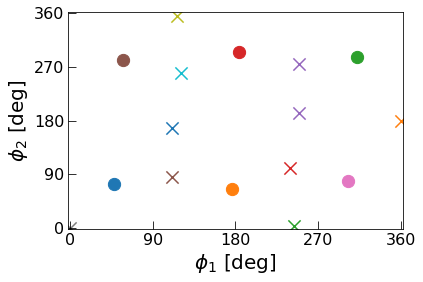

In [65]:


amd0 = 0.02**2
initial_solns = []
phi_eqs = []
already_found = False
for ig in inital_guesses:
    try:
        soln = newton_solve(ig,amd0,rtol = 1e-8,atol = 1e-13)
    except:
        continue
    phi1,phi2 = soln[:2]
    phi1,phi2=np.mod([phi1,phi2],2*np.pi)
    
    # Has this combinations of phi1 & phi2 occurred yet?
    if len(phi_eqs)>0:
        already_found = np.any(np.alltrue(np.isclose(np.array(phi_eqs),np.array((phi1,phi2))),axis=1))
    if not already_found:
        phi_eqs.append((phi1,phi2))
        jac = Dfun(soln,amd0)
        eigs = np.linalg.eigvals(jac)
        eigs_r = np.real(eigs)
        ell = np.alltrue(np.isclose(np.abs(eigs_r),0))
        # Save initial conditions for points at 
        # elliptic equilibria
        if ell:
            initial_solns.append(soln)
        mrker = 'o' if ell else 'x'
        plt.scatter(180 * phi1 / np.pi,180 * phi2 / np.pi,s=150,marker=mrker)
plt.xlim(-2,362)
plt.ylim(-2,362)
plt.xticks([0,90,180,270,360])
plt.yticks([0,90,180,270,360])
plt.tick_params(labelsize=16,size=8,direction='in')
plt.xlabel(r"$\phi_1$ [deg]",fontsize=20)
plt.ylabel(r"$\phi_2$ [deg]",fontsize=20)

# Get $N$-body simulations at equilibria

In [66]:
# A canonical transformation representing the composition of all the transformations we've 
# gone through so far. 
# Used to go from equlibiria -> poincare variables -> N-body simulations
ct_composite = CanonicalTransformation.Composite([ct,ct_rescale,ct_translate,ct_polar2cart])

In [67]:
active_mask = np.array([v in kam_rtc.qpvars for v in kam_rtc.full_qpvars])
idPhi4 = kam_rtc.full_qpvars.index(dPhi[3])

# Convert a solution to a rebound simulation
def to_sim(soln,amdval,sim0):
    vals = np.array(kam_rtc.full_values)
    vals[active_mask] = soln
    vals[idPhi4] = -1*amdval
    pvars = Poincare.from_Simulation(sim0)
    pvars.values = ct_composite.new_to_old_array(vals)
    sim = pvars.to_Simulation()
    sim.t = 0
    return sim
# Run a rebound simulation and get orbital angles and eccentricities
def get_angles_and_eccentricities(sim,times):
    N = len(times) 
    ps = sim.particles
    Npl = len(ps) - 1
    angs = np.zeros((N,3*Npl))
    eccs = np.zeros((N,Npl))
    for i,t in enumerate(times):
        sim.integrate(t)
        for j,p in enumerate(ps[1:]):
            eccs[i,j] = p.e
            angs[i,j] = p.l
            angs[i,j+Npl] = -1 * p.pomega
            angs[i,j+2*Npl] = -1 * p.Omega
    return angs,eccs
    

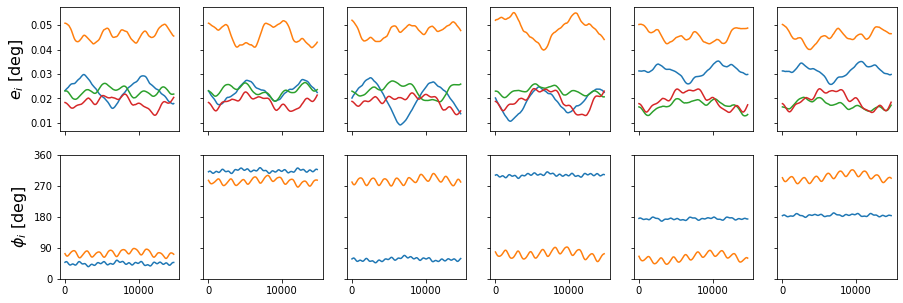

In [68]:
# Simulation times to get N-body results for
times = np.linspace(0,1,256) * 2e3 * sim.particles[1].P

# Set up plots
fig,ax = plt.subplots(2,6,figsize=(15,5),sharex=True,sharey='row')

# Loop over 6 stable equilibria, plot N-body solutions
for i,soln in enumerate(initial_solns):
    sim = to_sim(soln,amd0,sim)
    angs,eccs = get_angles_and_eccentricities(sim,times)
    ax[0,i].plot(times,eccs)
    res_angs = np.mod(np.array([A @ ang for ang in angs]),2*np.pi)
    ax[1,i].plot(times,180*res_angs[:,0]/np.pi)
    ax[1,i].plot(times,180*res_angs[:,1]/np.pi)
    
# make things  prettier
ax[0,0].set_ylabel(r"$e_i$ [deg]",fontsize = 16)
ax[1,0].set_ylabel(r"$\phi_i$ [deg]",fontsize = 16)
ax[1,0].set_yticks([0,90,180,270,360])

# AMD-dependence of Period ratios and eccentricities 
Here we'll choose one of our families of equilibria and look at how the planets eccentricities and distance to resonance, defined as $\Delta = \frac{j-1}{j}\frac{P_\mathrm{out}}{P_\mathrm{in}} - 1$ with $j$ particular to each pair's resonance.

In [69]:
init_soln = initial_solns[4]
phi1eq,phi2eq=np.array(init_soln[:2]) * 180/np.pi
print("Using equilibrium with phi1={:.1f} deg, phi2={:.1f} deg".format(phi1eq,phi2eq))
# The actual Kepler-223 system resides close to this equilibrium

Using equilibrium with phi1=176.0 deg, phi2=65.5 deg


In [70]:
Nsolns = 150
amdvals = np.logspace(np.log10(0.05 * amd0),np.log10(25*amd0),Nsolns)
guess = init_soln.copy()
eq_solns = np.zeros((Nsolns,guess.shape[0]))
for i,amdval in enumerate(amdvals):
    guess = newton_solve(guess,amdval)
    eq_solns[i] = guess
    
#for amdval in 

Text(0.5, 0, '$100\\times\\Delta$')

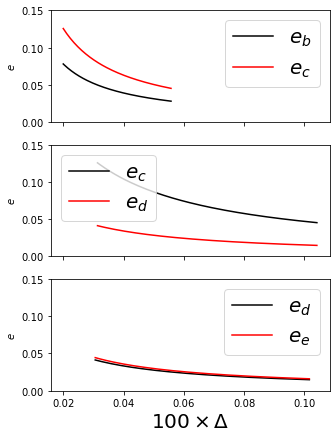

In [74]:
plstr='bcde'
fig,ax = plt.subplots(3,sharex=True,figsize=(5,7))
periods,eccs = np.zeros((2,len(eq_solns),4))
for i,soln in enumerate(eq_solns):
    sim = to_sim(soln,amdvals[i],sim)
    ps = sim.particles
    periods[i] = [p.P for p in ps[1:]]
    eccs[i] = [p.e for p in ps[1:]]
Deltas = periods[:,1:]/periods[:,:-1] * np.array([3/4,2/3,3/4])-1
for j,D in enumerate(Deltas.T):
    ax[j].plot(100*D,eccs[:,j],'k',label="$e_{}$".format(plstr[j]))
    ax[j].plot(100*D,eccs[:,j+1],'r',label="$e_{}$".format(plstr[j+1]))
    ax[j].legend(fontsize=20)
    ax[j].set_ylim(0,0.15)
    ax[j].set_ylabel("$e$")
ax[2].set_xlabel(r"$100\times\Delta$",fontsize=20)

# Migration Simulation
Maybe do something with this?

In [75]:
import reboundx as rbx

In [76]:
sim = rb.Simulation()
# Taken from Table 1 of Mills+ (2016)
Mstar = 1.125
Mearth = 3e-6

periods = [7.38449,9.84564,14.78869,19.72567] # Periods in days
masses = [7.4,5.1,8.0,4.8] # Masses in Earth masses


sim = rb.Simulation()
sim.units  = ("Msun","days","AU")
sim.add(m=Mstar)
factors = np.cumproduct(1 + np.array([0,0.005,0.005,0.01]))
for mass,per,f in zip(masses,periods,factors):
    sim.add(m = mass*Mearth,P =per * f)
sim.move_to_com()
extras = rbx.Extras(sim)
mod=extras.load_operator("modify_orbits_direct")
mod.params['p']=0
extras.add_operator(mod)
tau_alpha = 1e6 * sim.particles[1].P

mtrx=np.array([
    [p.m/p.a for p in sim.particles[1:]],
    [1,-1,0,0],
    [0, 1,-1,0],
    [0, 0,1,-1],
])
tau_inv_vals = np.linalg.inv(mtrx) @np.array([0,1/tau_alpha,1/tau_alpha,1/tau_alpha])
for p,tau_i in zip(sim.particles[1:],1/tau_inv_vals):
    p.params['tau_a'] = tau_i
    p.params['tau_e'] = -1 * np.abs(tau_i)/100


In [78]:
from celmech.nbody_simulation_utilities import set_timestep, get_simarchive_integration_results

In [79]:
sim.integrator = 'whfast'
set_timestep(sim,1/45.)
Tfin = 3e4 * sim.particles[1].P
Nout = 256
sim.automateSimulationArchive("migration.sa",interval=Tfin/Nout,deletefile=True)

In [80]:
sim.integrate(Tfin)

In [81]:
results=get_simarchive_integration_results("migration.sa")

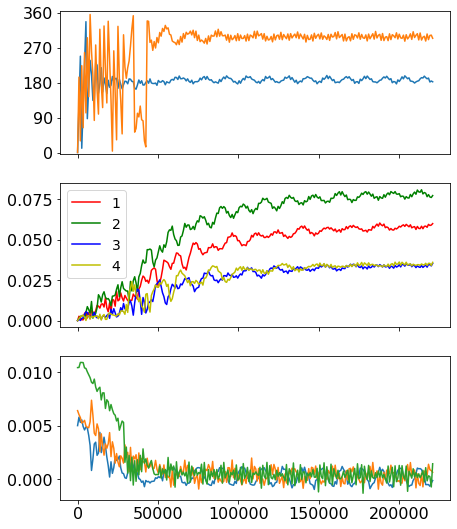

In [82]:
colors = 'rgby'
fig,ax = plt.subplots(3,1,sharex=True,figsize=(7,9))
angs = np.vstack((results['l'],-1*results['pomega'],-1*results['Omega'])).T
res_angs = np.mod(np.array([A @ ang for ang in angs]),2*np.pi)
ax[0].plot(results['time'],res_angs[:,0] * 180 / np.pi,'-')
ax[0].plot(results['time'],res_angs[:,1] * 180 / np.pi,'-')
ax[0].set_ylim(-5,365)
ax[0].set_yticks([0,90,180,270,360])
for i,e in enumerate(results['e']):
    ax[1].plot(results['time'],results['e'][i],color=colors[i],label=i+1)
ax[1].legend(fontsize=14)


ax[2].plot(results['time'],results['P'][1]/results['P'][0]*3/4-1)
ax[2].plot(results['time'],results['P'][2]/results['P'][1]*2/3-1)
ax[2].plot(results['time'],results['P'][3]/results['P'][2]*3/4-1)

for a in ax:
    plt.sca(a)
    plt.tick_params(labelsize=16)